# Demo of BISCUIT-NF on the Embodied AI iTHOR dataset

This notebook demonstrates the application and evaluation of BISCUIT-NF on the Embodied AI iTHOR dataset. We show how BISCUIT-NF allows for simulating interventions in latent space, and how it models a causal representation of the environment. Further, we reproduce the visualizations of the interaction maps in the paper. The notebook can be run locally or on Google Colab.

> **Note:** This notebook is intended to be run on a GPU. If you are running this notebook on Google Colab, make sure to enable GPU acceleration by going to `Runtime -> Change runtime type -> Hardware accelerator -> GPU`. Any GPU, such as a T4, P4, or P100, should work.

## Setup

In order to run the notebook, you need to install the dependencies. If you are running the notebook on Google Colab, you can skip this step. Otherwise, install the conda environment `biscuit` following the instructions in the [README](../README.md).

Further, to run the notebook on Google Colab, we need to clone the BISCUIT repository to the workspace. This is done in the following cell:

In [1]:
import os
import sys

# If you are running locally, the cloning is skipped
if not os.path.isdir('models/'):
    print("Cloning the repository...")
    !git clone https://github.com/phlippe/BISCUIT
    sys.path.append('BISCUIT/')
    # On Google Colab, we need to install the dependencies
    !pip install --quiet pytorch-lightning>=2.0 optuna ai2thor gdown
    !pip install --quiet --upgrade gdown

Cloning the repository...
Cloning into 'BISCUIT'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 118 (delta 15), reused 12 (delta 10), pack-reused 84 (from 1)
Receiving objects: 100% (118/118), 13.69 MiB | 15.67 MiB/s, done.
Resolving deltas: 100% (28/28), done.


We can then import our needed packages:

In [2]:
from typing import List, Any, Dict, Optional

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from matplotlib.patches import Patch
from tqdm.auto import tqdm
from glob import glob
import torch
import pytorch_lightning as pl

from models.biscuit_nf import BISCUITNF

Additionally, we will make use of the GPU if available:

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
!pip install ai2thor_colab

In [15]:
!pip install --upgrade ai2thor ai2thor-colab &> /dev/null
import ai2thor
import ai2thor_colab

ai2thor_colab.start_xserver()

In [16]:
!python BISCUIT/data_generation/data_generation_ithor.py


##################################################
Generating sequence 1 of 1...
##################################################
-> Seed: 3293867794
Attempt 1 failed with error: Unity process has exited - check ~/.config/unity3d/Allen\ Institute\ for\ Artificial\ Intelligence/AI2-THOR/Player.log for errors. Confirm that Vulkan is properly configured on this system using vulkaninfo from the vulkan-utils package. returncode=-11
Traceback (most recent call last):
  File "/content/BISCUIT/data_generation/data_generation_ithor.py", line 605, in generate_sequence
    controller, event = initialize_environment(seed)
  File "/content/BISCUIT/data_generation/data_generation_ithor.py", line 155, in initialize_environment
    controller = Controller(width=RESOLUTION,
  File "/usr/local/lib/python3.10/dist-packages/ai2thor/controller.py", line 518, in __init__
    self.start(
  File "/usr/local/lib/python3.10/dist-packages/ai2thor/controller.py", line 1436, in start
    self._start_unity_thread

Finally, we need to download the pretrained model and the small test sequence on which we want to perform the evaluation and visualization:

In [4]:
# Paths where to download the model and data to (relative to the current directory)
# Overall download size is about 50MB
CHECKPOINT_FILE = 'pretrained_models/BISCUITNF_iTHOR/BISCUITNF_40l_64hid.ckpt'
DATA_FOLDER = 'demo_data/ithor/'

# Download the model
if not os.path.exists(CHECKPOINT_FILE):
    print("Downloading the model...")
    !gdown 1GKFeEcoFFqLY3uMvrefS70THy6EcogqK
    !tar -xzvf pretrained_models.tar.gz
    !rm pretrained_models.tar.gz

# Download the data
if not os.path.exists(DATA_FOLDER):
    print("Downloading the data...")
    !gdown 1PEqpxrHdx8-RoApAPeeu8OQqK3qmqKqH
    !tar -xzvf demo_data.tar.gz
    !rm demo_data.tar.gz

Downloading...
From (original): https://drive.google.com/uc?id=1GKFeEcoFFqLY3uMvrefS70THy6EcogqK
From (redirected): https://drive.google.com/uc?id=1GKFeEcoFFqLY3uMvrefS70THy6EcogqK&confirm=t&uuid=b2e9ee3c-9428-4b97-b75d-56d4bd6246e3
To: /content/pretrained_models.tar.gz
100% 32.8M/32.8M [00:00<00:00, 41.8MB/s]
pretrained_models/
pretrained_models/AE_iTHOR/
pretrained_models/AE_iTHOR/AE_40l_64hid.ckpt
pretrained_models/BISCUITNF_iTHOR/
pretrained_models/BISCUITNF_iTHOR/BISCUITNF_40l_64hid.ckpt
Downloading...
From: https://drive.google.com/uc?id=1PEqpxrHdx8-RoApAPeeu8OQqK3qmqKqH
To: /content/demo_data.tar.gz
100% 15.4M/15.4M [00:00<00:00, 86.9MB/s]
demo_data/
demo_data/ithor/
demo_data/ithor/val_seq_1606868888.npz
demo_data/ithor/val_seq_1606868888_infos.json
demo_data/ithor/val_seq_1606868888_encodings.npz


### Loading data

As a first step to verify that the data was downloaded correctly, we can load the test sequence and visualize it:

In [5]:
# Simple function for plotting images
def show_img(imgs: Any,
             figure_title: str = None,
             titles: str = None):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axes = plt.subplots(1, len(imgs), figsize=(len(imgs) * 3.5, 3.5))
    if len(imgs) == 1:
        axes = [axes]
    for i, ax in enumerate(axes):
        if len(imgs[i].shape) == 3 and imgs[i].shape[0] in [3,4]:
            imgs[i] = imgs[i].permute(1, 2, 0)
        if isinstance(imgs[i], torch.Tensor):
            imgs[i] = imgs[i].detach().cpu().numpy()
        ax.imshow(imgs[i])
        ax.axis('off')
        if titles is not None:
            ax.set_title(titles[i], weight='bold')
    if figure_title is not None:
        fig.suptitle(figure_title, weight='bold', size=16)
    plt.tight_layout()
    plt.show()

In [6]:
# Load the frames and autoencoder encodings from the data
seq_file = sorted(glob(DATA_FOLDER + '*.npz'))[0]
encoding_file = seq_file.replace('.npz', '_encodings.npz')

frames = torch.from_numpy(np.load(seq_file)['frames']).float().to(device) / 255.0
encodings = torch.from_numpy(np.load(encoding_file)['encodings']).to(device)

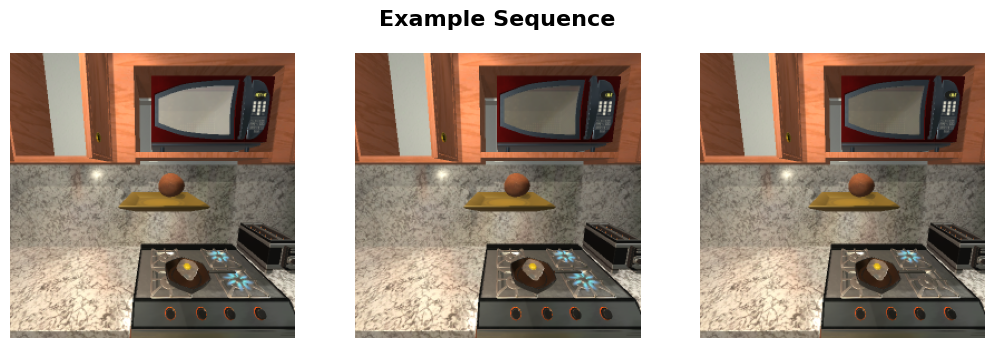

In [7]:
show_img([frames[90], frames[91], frames[92]], figure_title='Example Sequence')

You should see a sequence of three images, showing the kitchen environment of iTHOR. At the first time step, the agent is turning off the microwave, and at the second time step, the agent is turning off the front-right stove burner.

### Loading model

Next, we load the pretrained model:

In [8]:
model = BISCUITNF.load_from_checkpoint(CHECKPOINT_FILE)
model.to(device)
model.freeze()
_ = model.eval()

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.9.0 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint pretrained_models/BISCUITNF_iTHOR/BISCUITNF_40l_64hid.ckpt`
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.9.0 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint pretrained_models/AE_iTHOR/AE_40l_64hid.ckpt`


During the visualizations, we will use the model to perform interventions in latent space. For this, we need to find an alignment between the latent space and the causal variables. We use our correlation evaluation for this and assign each latent variable to the causal variable with the highest correlation. We do this below:

In [ ]:
CAUSAL_VARIABLE_NAMES = [
    'Cabinet',
    'Egg',
    'Microwave - Active',
    'Microwave - Open',
    'Plate',
    'Stove Front-Right',
    'Stove Front-Left',
    'Stove Back-Left',
    'Stove Back-Right',
    'Toaster'
]
causal_to_latents = {
    k: torch.where(model.last_target_assignment[:,idx] == 1)[0] for idx, k in enumerate(CAUSAL_VARIABLE_NAMES)
}
print('-' * 50)
print('Latent Dimensions for Causal Variables:')
print('-' * 50)
for k in causal_to_latents:
    print(f'{k}: {causal_to_latents[k].cpu().numpy()}')

Commonly, the Egg and the Plate with the potato have the most latent variables assigned to them since they are the most versatile objects in the environment. Note that not all latent variables necessarily contain information, and those without information are arbitrarily assigned to any causal variable here.

## Performing interventions in the latent space

With the model and dataset loaded, we are ready to analyse the learned causal representation. First, we reproduce the triplet prediction results, i.e. the interventions in latent space, from the paper. Note that the provided pretrained model slightly differs from the model used in the paper, and thus the results may differ slightly as well.

We first define a helper function to perform the intervention in latent space. The function takes (1) the input image on which we want to perform the interventions, (2) the image from which we want to take the intervention values, and (3) which latent/causal variables we want to intervene on. The first step is to encode both images into the learned causal representation. On the representation of the first input image, we replace the values of the latent variables corresponding to the specified causal variables in (3) with the values of the second input image. Afterwards, we simply reverse the flow to map the new latent vector back into the autoencoder representation space, and decode the image. The function then visualizes the image with the intervention applied.

In [ ]:
@torch.no_grad()
def triplet_prediction(
        image1_idx: int,
        image2_idx: int,
        vars_from_image2: List[str]):
    assert image1_idx >= 0 and image2_idx >= 0 and image1_idx < len(frames) and image2_idx < len(frames), \
        f'Invalid image indices {image1_idx}, {image2_idx}. Must be in [0, {len(frames)}).'
    image1_frame = frames[image1_idx].permute(1, 2, 0).cpu().numpy()
    image2_frame = frames[image2_idx].permute(1, 2, 0).cpu().numpy()
    image_encodings = torch.stack([encodings[image1_idx], encodings[image2_idx]], dim=0)
    image_latents, _ = model.flow.forward(image_encodings)
    image1_latents = image_latents[0]
    image2_latents = image_latents[1]
    image3_latents = image1_latents.clone()
    for var in vars_from_image2:
        image3_latents[causal_to_latents[var]] = image2_latents[causal_to_latents[var]]
    image3_encodings = model.flow.reverse(image3_latents[None])
    image3_frame = model.autoencoder.decoder(image3_encodings)[0]
    image3_frame = (image3_frame + 1.0) / 2.0
    image3_frame = image3_frame.permute(1, 2, 0).cpu().numpy()
    show_img([image1_frame, image2_frame, image3_frame],
             figure_title=f'Manipulating {", ".join(vars_from_image2)}',
             titles=['Input Image 1', 'Input Image 2', 'Generated Output'])

Using this function, we can apply various interventions. For example, we can intervene on the Microwave to turn it off:

In [ ]:
triplet_prediction(image1_idx=90,
                   image2_idx=99,
                   vars_from_image2=['Microwave - Active'])

Note how the microwave is turned off in the generated output while all other variables are identical to the original input image. Similarly, we can turn on the front-left stove burner, even simultaneously with the microwave:

In [ ]:
triplet_prediction(image1_idx=90,
                   image2_idx=99,
                   vars_from_image2=['Stove Front-Left', 'Microwave - Active'])

Notably, the Egg does not change its state although the stove is burning. This is because we only change the state of the stove, but force the state of the Egg to be identical to the original input image. This shows the strong disentanglement BISCUIT has learned, and its ability to perform novel interventions unseen during training.

Various other interventions are possible, of which we show a few below. Feel free to try out your own interventions!

In [ ]:
triplet_prediction(image1_idx=90,
                   image2_idx=99,
                   vars_from_image2=['Stove Front-Left'])

In [ ]:
triplet_prediction(image1_idx=30,
                   image2_idx=99,
                   vars_from_image2=['Microwave - Open', 'Cabinet'])

In [ ]:
triplet_prediction(image1_idx=99,
                   image2_idx=42,
                   vars_from_image2=['Microwave - Open', 'Stove Front-Right'])

In the results of the paper, we discussed how the Egg and Plate are the most difficult causal variables to model in the environment. Although BISCUIT was not able to perfectly disentangle them, its causal representation often allows for interventions on the Egg and Plate nonetheless. One example of such is shown below:

In [ ]:
triplet_prediction(image1_idx=30,
                   image2_idx=90,
                   vars_from_image2=['Microwave - Open', 'Egg'])

## Visualizing identified interaction variables

Next, we visualize the interaction variables identified by BISCUIT. For this, we take as input an image, and evaluate the predicted interaction variables for various action positions on the image. In iTHOR, an action corresponds to a position in the image, and thus we visualize the interaction variables by evaluating them for a grid of action positions. We first define a helper function to evaluate the interaction variables for a given image:

In [ ]:
@torch.no_grad()
def create_interaction_grid(image_idx: int,
                            batch_size: int = 1024):
    assert image_idx >= 0 and image_idx < len(frames), \
        f'Invalid image index {image_idx}. Must be in [0, {len(frames)}).'
    # Encode the image on which the action should be applied
    prev_img_encoding = encodings[image_idx]
    prev_img_latents = model.encode(prev_img_encoding[None])
    # Create a grid of actions
    resolution = frames.shape[-1]
    x, y = torch.meshgrid(torch.linspace(-1, 1, steps=resolution, device=device),
                          torch.linspace(-1, 1, steps=resolution, device=device),
                          indexing='xy')
    actions = torch.stack([x, y], dim=-1).flatten(0, 1)
    # Predict the interaction variables for each action
    outs = []
    for i in tqdm(range(0, actions.shape[0], batch_size), leave=False):
        batch_actions = actions[i:i+batch_size]
        batch_prev_state = prev_img_latents.expand(batch_actions.shape[0], -1)
        outs.append(model.prior_t1.get_interaction_quantization(batch_actions,
                                                                prev_state=batch_prev_state,
                                                                soft=True))
    pred_intv = torch.cat(outs, dim=0)
    pred_intv = pred_intv.unflatten(0, (x.shape[0], y.shape[0]))
    return pred_intv

Each interaction variable is predicted in the range [-1,1]. We visualize them by binarizing them, e.g. setting all values above 0 to 1 and all values below 0 to 0. We then visualize the binarized interaction variables for each causal variable on the image. For causal variables that have multiple latent variables, we only visualize one to reduce the clutter in the image. We do this below:

In [ ]:
def visualize_interaction_grid(image_idx: int,
                               grid: torch.Tensor,
                               latent_sub_index: Dict[str, int] = None,
                               threshold: float = -0.2):
    # Select the latents to visualize
    if latent_sub_index is None:
        latent_sub_index = {}
    latents = [causal_to_latents[k][latent_sub_index.get(k, 0)].item()
               for k in CAUSAL_VARIABLE_NAMES]
    # Binarize interaction variables
    binarized_grid = (grid.transpose(1, 0, 2) > threshold).astype(np.float32)
    # Create the image
    num_vars = len(latents)
    hues = [hsv_to_rgb([i/num_vars*0.9, 1.0, 1.0]) for i in range(num_vars)]
    img = np.zeros((binarized_grid.shape[0], binarized_grid.shape[1], 3), dtype=np.float32)
    for i, l in enumerate(latents):
        if binarized_grid[:, :, l].sum() > np.prod(binarized_grid.shape[:2])/2:
            binarized_grid[:, :, l] = 1 - binarized_grid[:, :, l]
        img += binarized_grid[:, :, l:l+1] * hues[i][None, None, :]
    # Normalize image
    counts_sum = binarized_grid[:,:,latents].sum(axis=-1, keepdims=True)
    img = img / np.maximum(counts_sum, 1)
    img += (counts_sum == 0) * np.array([[[0.9, 0.9, 0.9]]])
    # Overlay with original image
    orig_img = frames[image_idx].permute(1, 2, 0).cpu().numpy()
    new_img = 0.5 * img + 0.5 * orig_img
    # Plot
    _, axes = plt.subplots(1, 3, figsize=(3 * 3.5, 3.5))
    axes[0].imshow(orig_img)
    axes[0].set_title('Original Image')
    axes[1].imshow(img)
    axes[1].set_title('Interaction Grid')
    axes[2].imshow(new_img)
    axes[2].set_title('Overlay')
    axes[2].legend(handles=[Patch(color=hues[i], label=CAUSAL_VARIABLE_NAMES[i]) for i in range(num_vars)],
                   bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='$\\bf{Causal\ Variables}$')
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Finally, we use this function to visualize the interaction variables for some example images. Note that the `latent_sub_index` parameter specifies which latent variable to use for causal variables with multiple latent variables. This may require adjustment for new models. Further, for the Plate and Egg, different dimensions show slightly different behaviors. Feel free to try out your own images!

In [ ]:
latent_sub_index = {
    'Cabinet': 1,
    'Egg': 0,
    'Microwave - Active': 0,
    'Microwave - Open': 0,
    'Plate': 0,
    'Stove Front-Right': 1,
    'Stove Front-Left': 0,
    'Stove Back-Left': 0,
    'Stove Back-Right': 0,
    'Toaster': 0
}

for image_idx in [25, 70, 90]:
    grid = create_interaction_grid(image_idx=image_idx)
    visualize_interaction_grid(image_idx=image_idx,
                               grid=grid.cpu().numpy(),
                               latent_sub_index=latent_sub_index)

The interaction variables both dependent on the position and the image. For example, the interaction variable for the Egg switches to the front-left stove knob in the last image, since turning on the stove will cause the egg to get cooked. Similarly, the interaction variable for the Plate changes position depending on where the Plate is in the current frame. This shows that BISCUIT has learned to identify the interaction variables for each causal variable, and that these interaction variables are dependent on the image.

## Simulating Actions in the Environment

Finally, we show how BISCUIT can be used to simulate actions in the environment. For this, we first define a helper function to simulate an action in the environment. The function takes (1) the input image on which we want to perform the action, and (2) the action we want to perform. The function then encodes the input image into the latent space, and uses the learned transition prior to sample a next state based on the provided action. Finally, it decodes the latent vector back into the image space and visualizes the result. To be a bit more robust to potential reconstruction errors, we allow to pass the latents directly for long-term simulations. We do this below:

In [ ]:
@torch.no_grad()
def next_step_prediction(
        image: torch.Tensor,
        action: torch.Tensor,
        latents: Optional[torch.Tensor] = None,
        plot_images: bool = True):
    if latents is None:
        input_image = (image * 2.0) - 1.0
        latents = model.autoencoder.encoder(input_image[None])
        latents, _ = model.flow.forward(latents)
    new_latents, _ = model.prior_t1.sample(latents, action[None], num_samples=1)
    new_latents = new_latents.squeeze(1)
    new_encodings = model.flow.reverse(new_latents)
    new_image = model.autoencoder.decoder(new_encodings)[0]
    new_image = (new_image + 1.0) / 2.0
    if plot_images:
        new_image_frame = new_image.permute(1, 2, 0).cpu().numpy()
        old_image_frame = image.permute(1, 2, 0).cpu().numpy()
        clicked_image_frame = np.copy(old_image_frame)
        if action.ndim == 1:
            action = action[None]
        for i in range(action.shape[0]):
            pixel_y = int((action[i, 0].item() + 1.0) / 2.0 * image.shape[-2])
            pixel_x = int((action[i, 1].item() + 1.0) / 2.0 * image.shape[-1])
            clicked_image_frame[max(0, pixel_y-5):pixel_y+6,
                                max(0, pixel_x-5):pixel_x+6,
                                :] = np.array([1.0, 0.0, 0.0])
        show_img([old_image_frame, clicked_image_frame, new_image_frame],
                figure_title=f'Performing action {(action if action.ndim == 1 else action[0]).squeeze().cpu().numpy()}',
                titles=['Previous Frame', 'Click Location', 'New Sample'])
    return new_image, new_latents

As a first example, we can simulate four actions:
* the agent turning on the front-left stove burner;
* the agent opening the cabinet;
* the agent taking the Plate from the counter;
* the agent opening the microwave.

Since the sampling is stochastic and the model is not perfect, the results may not be perfectly stable for many steps and differ across seeds. Feel free to try out your own actions!

In [ ]:
latents = None
image = frames[0]
pl.seed_everything(42)

action_sequence = [
    (0.82, 0.12),
    (-0.5, -0.5),
    (0.7, -0.3),
    (-0.5, 0.2),
]

for action in action_sequence:
    image, latents = next_step_prediction(image=image,
                                          action=torch.tensor(action, device=device),
                                          latents=latents,
                                          plot_images=True)

Note in the example above how the stove takes several frames to fully fire up. This shows how BISCUIT learned to model the dynamics of the environment, and how it can be used to simulate actions in the environment.

### Multiple Actions at the Same Time

Since each latent variable is sampled independently conditioned on the previous time step, we can also simulate multiple actions at the same time. For example, we can simulate the agent turning on the microwave while picking up the plate at the same time. We do this by passing different actions to different latent variables, therefore simulating as if the agent is performing both actions at the same time. We do this below:

In [ ]:
latents = None
image = frames[0]
pl.seed_everything(42)

default_action = (0.0, 0.0)
causal_var_actions = {
    'Microwave - Active': (-0.5, 0.8),
    'Plate': (0.65, -0.43)
}

action = torch.tensor(default_action, device=device)
action = action[None].repeat(model.hparams.num_latents, 1)
for k in causal_var_actions:
    for latent_idx in causal_to_latents[k]:
        action[latent_idx] = torch.tensor(causal_var_actions[k], device=device)

image, latents = next_step_prediction(image=image,
                                      action=action,
                                      latents=latents,
                                      plot_images=True)

Such a combination of actions is not possible in the simulator and would be very difficult to achieve from entangled representations. This shows the benefits of learned causal representations with BISCUIT, and how they can be used to simulate unseen combinations of actions in the environment.

### Interactive Demo

If you are running this demo on Google Colab, we can visualize the prediction by an interactive demo. Feel free to click anywhere on the image below, and we will automatically show the prediction of the model of the next step (the prediction and reloading of the image can take a few seconds on Colab). To restart the demo from the beginning or choose a different starting image, simply re-run the cell. Note that since the model itself is not perfect, the model can sometimes face difficulty in predicting actions on the Egg and Plate, especially with multi-modal outcomes. Feel free to try out your own actions!

In [ ]:
try:
    from google.colab import output
except ImportError:
    print("Not running in Google Colab. Skipping the widget manager.")
else:
    !pip install --quiet ipympl
    output.enable_custom_widget_manager()

    %matplotlib ipympl

    latents = None
    image = frames[0]

    fig, ax = plt.subplots()
    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    load_text = ax.text(image.shape[-1]//2,
                        image.shape[-2]//2,
                        'Loading...',
                        fontsize='x-large',
                        weight='bold',
                        va='center',
                        ha='center',
                        backgroundcolor=(1.0, 0.8, 0.8))
    load_text.set_visible(False)
    ax.axis('off')

    def onclick(event):
        global image, latents
        load_text.set_visible(True)
        fig.canvas.draw()
        ix, iy = event.xdata, event.ydata
        ix = (ix / image.shape[-1] - 0.5) * 2.0
        iy = (iy / image.shape[-2] - 0.5) * 2.0
        print(f'Clicked at x={ix:.2f}, y={iy:.2f}')
        image, latents = next_step_prediction(image=image,
                                              action=torch.tensor([iy, ix],
                                                                  dtype=torch.float32,
                                                                  device=device),
                                              latents=latents,
                                              plot_images=False)
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        load_text.set_visible(False)
        fig.canvas.draw()

    cid = fig.canvas.mpl_connect('button_press_event', onclick)